## 0. Import Libraries

For ease of use and ram, run each indices in different sessions

In [1]:
import climextremes
import sys 
import time

import numpy as np
import pandas as pd
import xarray as xr

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

## 1. Data Options

In [2]:
# change these
season = 'DJF' # DJF, JJA,
time_resample = 6 # options: 1, 3, 6 (resampling)

# bias algorithm
bias_algo = 'QDM'

# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# general data path
path_general = fr'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'

# variable name
name_variable_cosmo = 'TOT_PREC'

# saving path (saving with cosmo var name for both era5 and cosmo)
path_save = fr'data/{name_variable_cosmo}/'

# years
years = np.arange(1985, 2006, dtype=int)

## 2. Intensity Indices

### 2.1 Open Data

#### 2.1.1 Indice Data

In [119]:
intensity_indice_name = fr'rx{time_resample}hr'
intensity_idx_cosmo = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{intensity_indice_name}_198501_200512.nc")[name_variable_cosmo]

In [120]:
# get the attributes in a dict
intensity_indice_attrs = intensity_idx_cosmo.attrs

In [121]:
intensity_idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
[169743 values with dtype=float64]
Coordinates:
  * rlon     (rlon) float32 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
  * rlat     (rlat) float32 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
  * year     (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    computation:  grouped by year and took maximum over time dimension
    indice_name:  rx6hr

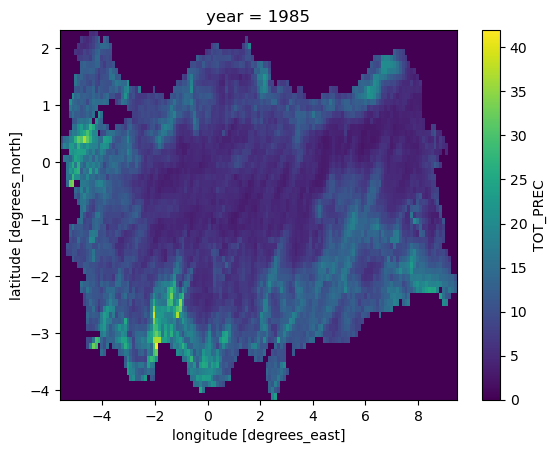

In [122]:
intensity_idx_cosmo[0].plot()

#### 2.1.2 Turkey Vector Data

In [123]:
turkey_bool = xr.open_dataset(fr"{path_save}/cosmo/BC/vectorized_turkey.nc")

### 2.2 Clip Indice Data to Turkey

In [124]:
intensity_idx_cosmo = intensity_idx_cosmo.where(turkey_bool==1)[name_variable_cosmo]

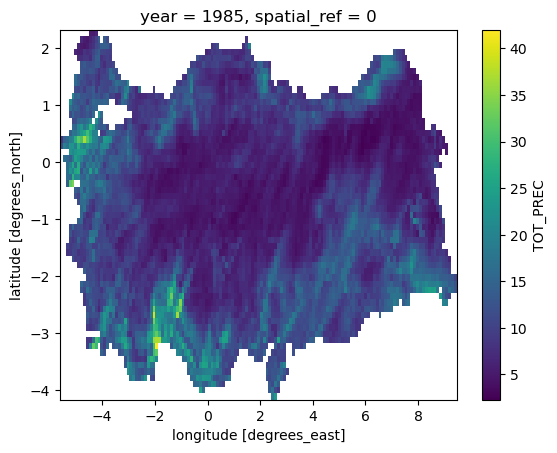

In [125]:
intensity_idx_cosmo[0].plot()

In [126]:
# stack data
dt_test = intensity_idx_cosmo.stack(horizontal = ('rlat', 'rlon'))

In [127]:
dt_test

<xarray.DataArray 'TOT_PREC' (year: 21, horizontal: 8083)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon          (horizontal) float32 26.18 26.31 26.45 ... 45.33 45.47 45.62
    lat          (horizontal) float32 35.68 35.69 35.69 ... 41.63 41.62 41.6
  * year         (year) int64 1985 1986 1987 1988 1989 ... 2002 2003 2004 2005
    spatial_ref  int64 ...
  * horizontal   (horizontal) MultiIndex
  - rlat         (horizontal) float64 -4.11 -4.11 -4.11 -4.11 ... 2.27 2.27 2.27
  - rlon         (horizontal) float64 -5.55 -5.44 -5.33 -5.22 ... 9.19 9.3 9.41
Attributes:
    computation:  grouped by year and took maximum over time dimension
    indice_name:  rx6hr

In [128]:
np.shape(dt_test)

(21, 8083)

In [13]:
# to pd df
dt_test_pd = pd.DataFrame(dt_test.values).dropna(axis=1)

In [14]:
# find no-nan grids
nonan_grids = dt_test_pd.columns.values

In [15]:
nonan_grids

array([  73,   74,  185, ..., 7956, 7957, 7958])

In [16]:
len(nonan_grids)

5579

In [17]:
np.shape(dt_test_pd.values)

(21, 5579)

In [18]:
# to mitigate gev warnings and errors (do not include 0)
#dt_test_pd = dt_test_pd.where(dt_test_pd!=0, 0.01)

### 2.3 GEV

In [55]:
def delete_last_lines(num_grid, grid): 
    
    # display setting
    if not num_grid - grid == 1:
        clear_output(wait=True)
        
def fit_stationary_gev_model(data, grid, return_period):
    """
    Returns:
    location, scale, shape, return_value, neg_log_likelihood
    
    """

    intensity_model = climextremes.fit_gev(y=data.loc[:,grid].values,
                                           returnPeriod = return_period,
                                           getParams = True,
                                           getFit = True,
                                           #optimArgs = {'method': 'BFGS'},
                                           #bootSE = True
                                             )
    
    location = intensity_model['mle'][0]
    scale = intensity_model['mle'][1]   
    shape = intensity_model['mle'][2]   
    return_value = intensity_model['returnValue'][0]
    neg_log_likelihood = intensity_model['nllh'][0]
    
    return location, scale, shape, return_value, neg_log_likelihood

#### 2.3.1 Stationary

In [88]:
%%time
# build a stationary GEV model

# introduce parameters
return_period=20
num_param = 5
num_year = np.shape(dt_test_pd)[0]
num_grid = np.shape(dt_test_pd)[1]

# in order: location, scale, shape, return_value, neg_log_likelihood
parameter_array = pd.DataFrame(index = np.arange(num_param),
                               columns = nonan_grids) # 5 for parameter space
error_array = []

# loop over grids
for grid in nonan_grids:
    
    # fit stationary gev model
    try:
        gev = fit_stationary_gev_model(dt_test_pd, 
                          grid, 
                          return_period,
                         )

        # fill in required parameters
        for param_space in range(num_param):
            parameter_array.loc[param_space, grid] = gev[param_space]
        
        # display results
        print(fr"done with grid number: {grid}")
        
    except:
        
        # report grid
        error_array.append(grid)
        
        # fill in required parameters with nan
        for param_space in range(num_param):
            parameter_array.loc[param_space, grid] = np.nan
            
        # display results
        print(fr"problem with grid number: {grid}")
        
    # display setting
    delete_last_lines(num_grid, grid)

CPU times: user 4min 35s, sys: 5min 38s, total: 10min 13s
Wall time: 3min 21s


In [246]:
# rename parameter array
parameter_array.rename(index={0:'location',
                              1:'scale',
                              2:'shape',
                              3:'return_value',
                              4:'neg_log_likelihood',
                              }, inplace=True)

In [247]:
parameter_array

,73,74,185,186,209,210,211,212,320,321,...,7819,7820,7821,7822,7824,7825,7873,7956,7957,7958
location,15.755349,16.069698,14.323642,13.505516,13.587518,13.074039,10.472313,10.199428,14.426732,15.063771,...,6.352711,7.368552,8.110337,9.183865,8.222081,7.153092,3.994329,6.05768,5.518115,6.237166
scale,4.46925,5.396753,4.497181,2.905277,3.071032,3.035864,2.144425,3.389097,4.231804,4.583825,...,1.950007,1.711346,1.594775,1.842718,2.11037,1.644632,0.688747,2.277034,1.718272,1.614997
shape,-0.507647,-0.656522,-0.196763,-0.019189,0.138714,0.161149,0.069657,0.023169,-0.172642,-0.166863,...,0.205648,0.280642,0.343714,0.436173,-0.040588,0.077454,0.848429,0.168951,0.301305,0.427803
return_value,22.610082,23.120389,24.439026,21.893451,24.875164,24.638926,17.548462,20.620154,24.260263,25.799396,...,14.336115,15.305068,16.34921,20.391647,14.1272,12.645548,13.271964,14.841233,13.771026,15.913475
neg_log_likelihood,58.654635,60.906639,62.516811,55.507055,58.457609,58.491812,50.089479,59.249866,61.54755,62.98098,...,49.567085,47.866052,47.069127,51.00113,48.423707,44.588026,34.776307,52.463988,48.192749,48.269165


In [138]:
np.array(error_array)

array([6395, 6205, 5828, 5613, 5280, 5263, 5247, 5193, 5143, 4967, 4752,
       4713, 4575, 2831, 2724, 2555])

#### 2.3.2 Recover Xarray Data

In [316]:
dt_recover = dt_test[0].copy(deep=True).to_dataset()
dt_recover = dt_recover.rename({'TOT_PREC':'return_value'})

In [317]:
dt_recover

<xarray.Dataset>
Dimensions:       (horizontal: 8083)
Coordinates:
    lon           (horizontal) float32 26.18 26.31 26.45 ... 45.33 45.47 45.62
    lat           (horizontal) float32 35.68 35.69 35.69 ... 41.63 41.62 41.6
    year          int64 1985
    spatial_ref   int64 0
  * horizontal    (horizontal) MultiIndex
  - rlat          (horizontal) float64 -4.11 -4.11 -4.11 ... 2.27 2.27 2.27
  - rlon          (horizontal) float64 -5.55 -5.44 -5.33 -5.22 ... 9.19 9.3 9.41
Data variables:
    return_value  (horizontal) float64 nan nan nan nan nan ... nan nan nan nan

In [318]:
# empty the data values with nan
nans = np.empty(8083)
nans[:] = np.nan

dt_recover['return_value'][:] = nans

In [319]:
parameters = ['location',
              'scale',
              'shape',
              'return_value',
              'neg_log_likelihood']

# create new variables (should be copy, otherwise all variable values change)
for param in parameters:
    dt_recover = dt_recover.assign({fr'{param}': lambda dt_recover: dt_recover.return_value.copy(deep=True)})

In [320]:
dt_recover

<xarray.Dataset>
Dimensions:             (horizontal: 8083)
Coordinates:
    lon                 (horizontal) float32 26.18 26.31 26.45 ... 45.47 45.62
    lat                 (horizontal) float32 35.68 35.69 35.69 ... 41.62 41.6
    year                int64 1985
    spatial_ref         int64 0
  * horizontal          (horizontal) MultiIndex
  - rlat                (horizontal) float64 -4.11 -4.11 -4.11 ... 2.27 2.27
  - rlon                (horizontal) float64 -5.55 -5.44 -5.33 ... 9.19 9.3 9.41
Data variables:
    return_value        (horizontal) float64 nan nan nan nan ... nan nan nan nan
    location            (horizontal) float64 nan nan nan nan ... nan nan nan nan
    scale               (horizontal) float64 nan nan nan nan ... nan nan nan nan
    shape               (horizontal) float64 nan nan nan nan ... nan nan nan nan
    neg_log_likelihood  (horizontal) float64 nan nan nan nan ... nan nan nan nan

In [321]:
# integrate parameters from parameter_array into our xarray data
for param in parameters:
    dt_recover[param][nonan_grids] = parameter_array.loc[param].values

In [322]:
# unstack to lat lon from horizontal
dt_recover_unstack = dt_recover.unstack()

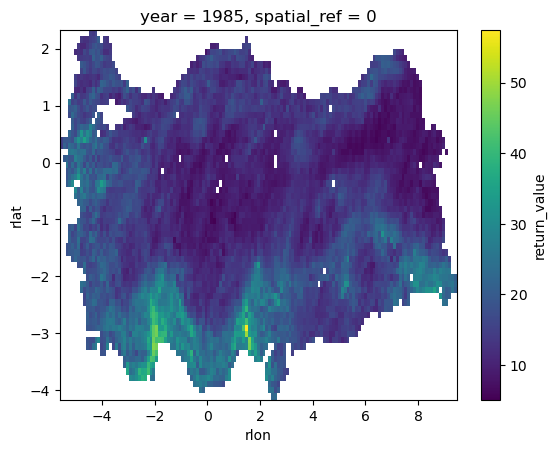

In [327]:
dt_recover_unstack['return_value'].plot()

In [329]:
# save as stationary or nonstat
dt_recover_unstack.to_netcdf(fr"{path_save}/cosmo/BC/GEV/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{intensity_indice_name}_GEV_stationary_198501_200512.nc")

## Extra

In [61]:
np.shape(np.array([[1,2,3],
         [4,5,6]]))

(2, 3)

In [71]:
np.array([[1,2,3],
         [4,5,6]]).transpose().flatten()

array([1, 4, 2, 5, 3, 6])

In [91]:
mm = pd.DataFrame(index = np.arange(num_param),
                               columns = nonan_grids)

In [92]:
mm

,73,74,185,186,209,210,211,212,320,321,...,7819,7820,7821,7822,7824,7825,7873,7956,7957,7958
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
climextremes.fit_gev(y=dt_test_pd.loc[:, 5646].values,
                                           returnPeriod = 20,
                                           getParams = True,
                                           getFit = True,
                                           #optimArgs = {'method': 'BFGS'}
                                             )

{'mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'mle': array([6.73406947, 0.98548034, 1.12758159]),
 'se_mle_names': array(['location', 'scale', 'shape'], dtype='<U8'),
 'se_mle': array([0.28419705, 0.37703893, 0.42845421]),
 'nllh': array([44.95784791]),
 'returnValue': array([30.74934843]),
 'se_returnValue': array([23.93894095]),
 'info': {'convergence': array([0], dtype=int32),
  'counts_names': array(['function', 'gradient'], dtype='<U8'),
  'counts': array([104.,  nan]),
  'message': None,
  'failure': array([0], dtype=int32)},
 'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
  'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
  'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'in.data': array([1], dtype=int32),
  'x.fun': None,
  'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
         '13', '14

In [48]:
climextremes.calc_riskRatio_gev(returnValue=0.2,
                                y1 = dt_test_pd.loc[:, 185].values,
                                y2 = dt_test_pd.loc[:, 185].values,
                                optimArgs = {'method': 'BFGS'},
                                ciType = 'lrt',
                                getFit = True)

{'logRiskRatio': array([0.]),
 'se_logRiskRatio': array([0.09414298]),
 'riskRatio': array([1.]),
 'ci_riskRatio_lrt_names': array(['0.05', '0.95'], dtype='<U4'),
 'ci_riskRatio_lrt': array([0.87718788, 1.18652614]),
 'fit1': {'info': {'convergence': array([0], dtype=int32),
   'counts_names': array(['function', 'gradient'], dtype='<U8'),
   'counts': array([25,  7], dtype=int32),
   'message': None,
   'failure': array([0], dtype=int32)},
  'fit': {'call': Rlang( fevd(x = .y ~ 1, data = x, location.fun = locationFun, scale.fun = scaleFun,  ),
   'data.name': array(['.y ~ 1', 'x'], dtype='<U6'),
   'weights': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]),
   'in.data': array([1], dtype=int32),
   'x.fun': None,
   'missing.values_names': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
          '13', '14', '15', '16', '17', '18', '19', '20', '21'], dtype='<U2'),
   'missing.values': array([0, 0, 0, 0, 0, 0, 0